# Мое решение Задачи 2 "Спрос на бронирование отелей"

Я работаю на удаленном сервер с ГПУ через VS code. Поэтому у меня нет кода который загружает или скачивает данные с Google Colab.

Данные содержат сведения о спросе на отели. Датасет содержит 119 390 наблюдений. Каждое наблюдение представляет собой бронирование отеля. Набор данных учитывает бронирования, которые должны прибыть в период с 1 июля 2015 года по 31 августа 2017 года, включая фактически поступившие и отмененные бронирования.

Данные содержат сведения о **70 146** отелях.
- Тренировочный набор - **44 634 строк**.
- Тестовый набор - **25 512 строк**.

In [1]:
# установим AutoML фреймворк от Сбера - LightAutoML(LAMA)
# это позволит довольно быстро проверять различные гипотезы и 
# отбирать лучшие решения.
# !pip install -U lightautoml

In [2]:
# иморитирование всех необходимых библиотек
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# импорты из LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Считывание данных

In [3]:
# Считываем тренировочные данные
train = pd.read_csv("data/train_final.csv")

print(f"Train dataset shape: {train.shape}")

Train dataset shape: (44638, 29)


In [4]:
# Считываем тестовые данные
test = pd.read_csv("data/test_final.csv")

print(f"Test dataset shape: {test.shape}")

Test dataset shape: (23525, 28)


In [5]:
# Посмотрим как выглядят данные
train.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,3,2016,February,7,12,0,2,2,...,E,F,0,No Deposit,0,Transient,81.0,1,0,2016-02-14
1,City Hotel,1,50,2016,November,47,18,1,2,2,...,A,A,0,No Deposit,0,Transient,93.6,0,2,2016-10-09
2,City Hotel,0,14,2015,September,37,7,1,5,2,...,F,F,0,No Deposit,0,Contract,166.0,0,3,2015-09-13
3,City Hotel,0,18,2015,December,50,6,2,0,2,...,A,A,0,No Deposit,0,Transient,107.0,0,0,2015-12-08
4,City Hotel,1,263,2016,September,40,29,2,4,2,...,A,A,0,No Deposit,0,Transient,100.3,0,0,2016-01-18


## Исследование данных

Прежде чем переходить к непосредственному построению модели, в первую очередь необходимо исследовать имеющихся у вас набор данных:
1. Какую задачу вы решаете (классификация, регрессия) и какая переменная является целевой?
2. Сколько переменных в данных и какого они типа?
3. Имеются ли в данных пропуски?

In [6]:
print("Number of missing values in train dataset:")
print(train.isna().sum())
print("Number of missing values in test dataset:")
print(test.isna().sum())

Number of missing values in train dataset:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44638 entries, 0 to 44637
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           44638 non-null  object 
 1   is_canceled                     44638 non-null  int64  
 2   lead_time                       44638 non-null  int64  
 3   arrival_date_year               44638 non-null  int64  
 4   arrival_date_month              44638 non-null  object 
 5   arrival_date_week_number        44638 non-null  int64  
 6   arrival_date_day_of_month       44638 non-null  int64  
 7   stays_in_weekend_nights         44638 non-null  int64  
 8   stays_in_week_nights            44638 non-null  int64  
 9   adults                          44638 non-null  int64  
 10  children                        44638 non-null  float64
 11  babies                          44638 non-null  int64  
 12  meal                            

**Проверим баланс классов.**

В задаче классификации данные называются несбалансированными (Imbalanced Data), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что «классы не сбалансированы».

In [8]:
train['is_canceled'].value_counts()

0    31354
1    13284
Name: is_canceled, dtype: int64

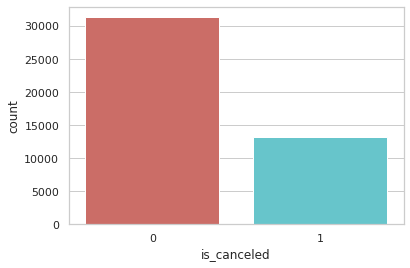

In [9]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
y_data = pd.DataFrame(train['is_canceled'])
sns.countplot(x='is_canceled', data=y_data, palette='hls')
plt.show()

## Предобработка данных

Исходя из анализа данных, можно сделать выводы:
- в данных пропусков нет
- в данных имеются категориальные признаки
- в задаче решается задача бинарной классификации
- существует небольшой дисбаланс классов отмененных бронирований отелей (класс 1) примерно в два раза меньше, чем неотмененных (класс 2).
Это хорошо для владельцев отелей, но может создать некоторый bias в нашей модели.
Однако итоговая метрика соревнования accuracy, данная метрика не учитывает дисбаланс классов.

### Кодирование признаков

**Категориальные признаки называют по-разному: факторными, номинальными.**

Их значения определяют факт принадлежности к какой-то категории. Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа. 

**Категориальные** признаки называют по-разному: **факторными**, **номинальными**. Их значения определяют факт принадлежности к какой-то категории. 

Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа.

In [10]:
# Перечислим колонки которые являются категоритальными признаками
# выбрали датафраме test, чтобы в списке признаков не было целевой переменной

category_features = []
for col_name in test.loc[:, train.dtypes == object].columns:
    print(col_name)
    category_features.append(col_name)

hotel
arrival_date_month
meal
country
market_segment
distribution_channel
reserved_room_type
assigned_room_type
deposit_type
customer_type
reservation_status_date


In [11]:
# Перечислим колонки которые являются количественными(числовыми) признаками
# выбрали датафраме test, чтобы в списке признаков не было целевой переменной

numeric_features = []
for col_name in test.loc[:, train.dtypes != object].columns:
    print(col_name)
    numeric_features.append(col_name)

lead_time
arrival_date_year
arrival_date_week_number
arrival_date_day_of_month
stays_in_weekend_nights
stays_in_week_nights
adults
children
babies
is_repeated_guest
previous_cancellations
previous_bookings_not_canceled
booking_changes
days_in_waiting_list
adr
required_car_parking_spaces
total_of_special_requests


У используемой мной библиотеки lightAutoLM от Сбера есть своя встроенная обработка категориальных данных.
Нам нужно пр постановке задачи просто указать какие колонки являются количественными(числовыми), а какие категориальными.
Что мы и сделаем.

Бывает, что распределения числовых признаков в предоставленных данных могут сильно отличаться.
Например, некоторый параметр "цена бронирования" имеет в train выборе распределение от 0 до 1000, а в тесте от 5000 до 10000.
Таким образом модель обученная по выборке train будет работать в диапазоне значений который не встречается в test выборке.
Простейший способ борьбы с этим явлением - избавиться от такого признака при обучении модели.

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


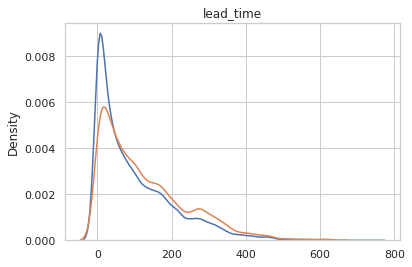

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


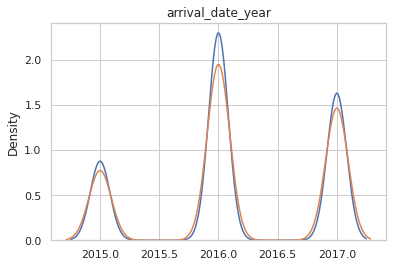

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


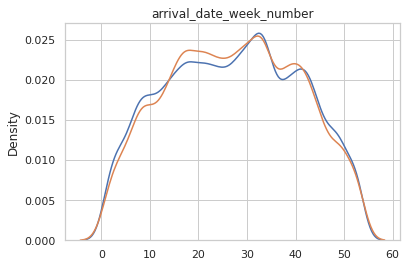

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


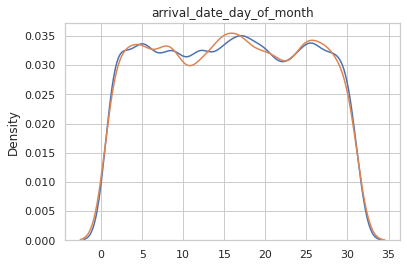

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


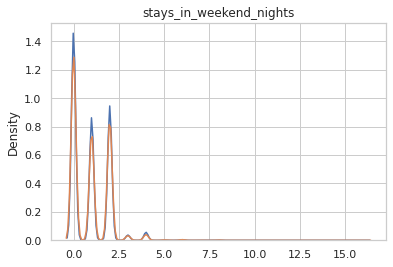

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


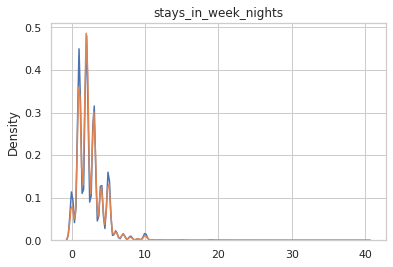

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


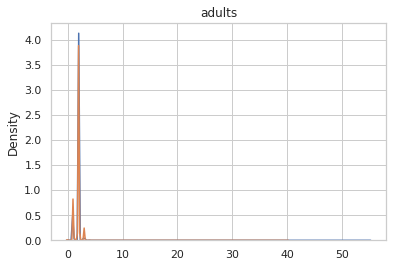

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


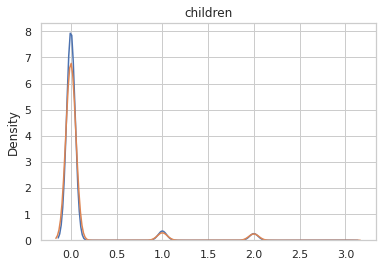

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


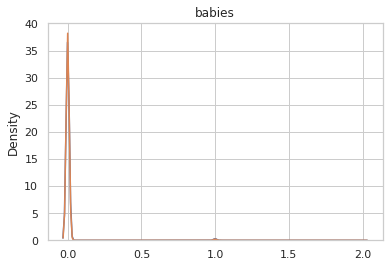

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


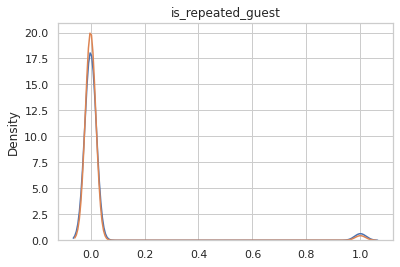

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


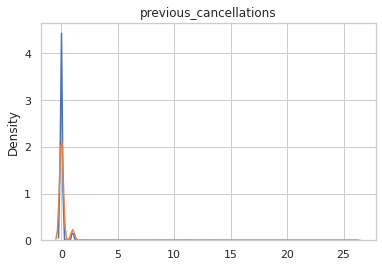

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


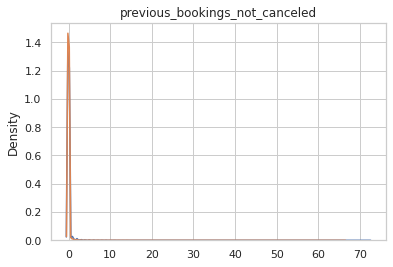

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


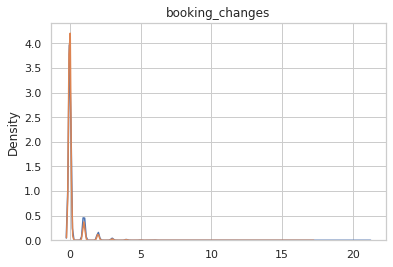

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


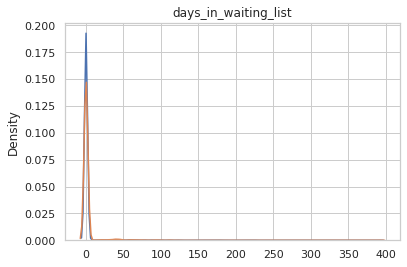

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


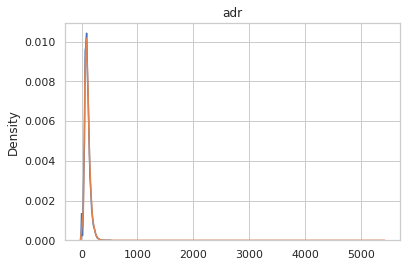

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


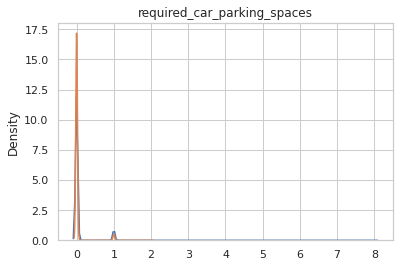

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


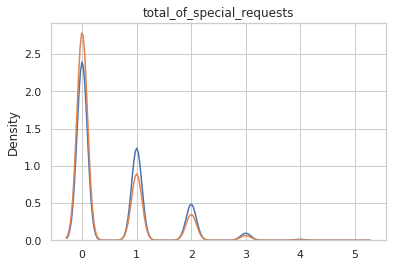

In [12]:
# Мы хотим посмотреть распределения значений у количественных признаков между выборками train и test

for col_i in test.loc[:, train.dtypes != object].columns:
    sns.distplot(train[[col_i]], hist=False)
    sns.distplot(test[[col_i]], hist=False)
    plt.title(col_i)
    plt.show()

## Вывод -  выборки train и test гомогенны
Мы видим, что распределения очень похожи а выборки train и test - гомогенны. Можно работать со всеми числовыми признаками )

## Разделяем train-выборку на train (80%) и val(20%)

In [13]:
# Разобьем выборку на обучающую и валидационную
tr_data, valid_data = train_test_split(train, 
                                       test_size=0.2, 
                                       stratify=train['is_canceled'], 
                                       random_state=42)

print(f'Parts sizes: tr_data = {tr_data.shape}, valid_data = {valid_data.shape}')

Parts sizes: tr_data = (35710, 29), valid_data = (8928, 29)


## Обучение модели

Теперь наши данные готовы для обучения модели.

## Ставим задачу машинного обучения используем все

In [14]:
# https://lightautoml.readthedocs.io/en/latest/python_api/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task
task = Task('binary', loss= 'logloss', metric = 'accuracy')

In [15]:
category_features

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status_date']

In [16]:
numeric_features

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [17]:
roles = {'target': 'is_canceled',
         'numeric': numeric_features,
         'category': category_features
         }

In [18]:
# Эксперименты показали, что в итоговой блендинг модели наибольший вклад
# около 95% имеет модель градиентного бустинга lgb.
# Вклад Логистической регрессии с l2-регуляризацией менее 1%.
# Вклад градиентного бустинга CatBoost составил 5%.
# В итоговом решении я оставил только эту модель.
automl = TabularAutoML(task = task, 
                    timeout = 3600 * 3, # 3600 секунд = 1 час
                    general_params = {'use_algos': [['lgb']]},
                    reader_params = {'n_jobs': 12},
                    timing_params ={'mode': 0}
                    )

In [19]:
# запускаем обучение на данных и подбор оптимальных параметров
# из ансамбля моделей
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose=4)

[07:18:26] Stdout logging level is DEBUG.
[07:18:26] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[07:18:26] Task: binary

[07:18:26] Start automl preset with listed constraints:
[07:18:26] - time: 10800.00 seconds
[07:18:26] - CPU: 4 cores
[07:18:26] - memory: 16 GB

[07:18:26] Train data shape: (35710, 29)

[07:18:27] Feats was rejected during automatic roles guess: []
[07:18:27] Layer 1 train process start. Time left 10798.88 secs
[07:18:27] Training until validation scores don't improve for 200 rounds
[07:18:27] [100]	valid's binary_error: 0.0854102
[07:18:27] [200]	valid's binary_error: 0.058107
[07:18:27] [300]	valid's binary_error: 0.0455055
[07:18:28] [400]	valid's binary_error: 0.0401848
[07:18:28] [500]	valid's binary_error: 0.0382246
[07:18:28] [600]	valid's binary_error: 0.0358443
[07:18:28] [700]	valid's binary_error: 0.0338841
[07:18:28] [800]	valid's binary_error: 0.0329039
[07:18:28] [900]	valid's binary_error: 0.032

Тут некоторая тонкость использования метдов **automl.fit_predict()** и **automl.predict()**.

Когда automl обучает модели методом **fit_predict()** это происходит с помощью кросс валидации (в нашем случае на 5 подвыборках из обучающей выборки). 

В процессе этого **automl** будет собирать статистику по фолдам, которые в данный момент являются валидационными и записывать ее.

Поэтому и предсказанные значения по валидационным фолдам и полученные по ней метрики будут получены из метода automl.fit_predict(обучающая_выборка).

automl.predict(данные) использует уже готовый полученный ансамбль моделей МЛ, некакого разбиения на подвыборки тут нет. Его праивльно использовать на тестовой выборке, - тех данных которые не участвовали при обучени модели.

Предсказывать на automl.predict(обучающая_выборка) не правильно, таким образом мы померим метрику на тех данных на которых учили модель. А правильно делать это только на валлидационых фолдах при кросс валидации.

### Сохраним полученный ансамбль моделей в файл

In [20]:
model_path = 'model/lightautoml_model_1.pkl'
oof_pred_path = 'model/lightautoml_model_1_oof_pred_1.pkl'

In [21]:
# сохраним полученный ансамбль моделей и его предсказания на тестовой выборке
joblib.dump(automl, model_path)
joblib.dump(oof_pred, oof_pred_path)

['model/lightautoml_model_1_oof_pred_1.pkl']

### Загрузим сохраненую ранее модель из файла

In [22]:
porog = 0.5

In [23]:
automl = joblib.load(model_path)
oof_pred = joblib.load(oof_pred_path)

In [24]:
# проверка полученного ансамбля на валидационной выборке
valid_pred = automl.predict(valid_data)

In [25]:
valid_pred = (valid_pred.data[:, 0] > porog).astype(int)
valid_pred

array([0, 0, 0, ..., 1, 0, 1])

In [26]:
np.unique(valid_pred, return_counts=True)

(array([0, 1]), array([6529, 2399]))

In [27]:
valid_y_true = valid_data['is_canceled'].values
valid_y_true

array([0, 0, 0, ..., 1, 0, 1])

In [28]:
np.unique(valid_y_true, return_counts=True)

(array([0, 1]), array([6271, 2657]))

In [29]:
# соберем данные для оценки метрик по фолдам кросс валидации
cross_val_train_y_true = tr_data['is_canceled'].values
cross_val_train_pred = (oof_pred.data[:, 0] > porog).astype(int)

In [30]:
# оценка полученной метрики на валидационном наборе данных
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f"Кросс валидация accuracy_score: {accuracy_score(cross_val_train_y_true, cross_val_train_pred)}")
print(f"Валидационная выборка accuracy_score: {accuracy_score(valid_y_true, valid_pred)}")

print(f"Кросс валидация precision_score: {precision_score(cross_val_train_y_true, cross_val_train_pred)}")
print(f"Валидационная выборка  precision_score: {precision_score(valid_y_true, valid_pred)}")

print(f"Кросс валидация precision_score: {recall_score(cross_val_train_y_true, cross_val_train_pred)}")
print(f"Валидационная выборка precision_score: {recall_score(valid_y_true, valid_pred)}")

Кросс валидация accuracy_score: 0.9635396247549706
Валидационная выборка accuracy_score: 0.9652777777777778
Кросс валидация precision_score: 0.9790403780951402
Валидационная выборка  precision_score: 0.9891621508962067
Кросс валидация precision_score: 0.8966782723252094
Валидационная выборка precision_score: 0.8931125329318781


## Обучение модели на всей обучающей выборке и предсказание на тестовых данных

Мы подобрали параметры обучения убедились что они работают хорошо по кросс валидации по 5 фолдам на 80% обучающей выборки.
И протестировали наш алгоритм на 20% валидационной выборки.

Теперь мы используя все подобранные параметры и настройки просто обучим алгоритм МЛ на кросс валидации по 5 фолдам, но уже на всей обучающей выборке. 

Согласно лучшим практикам встречающимся на kaggle это дает дополнительный прирост к точности за счет расширения выборки обучающих данных для модели. Контроль метрик и ранней остановки обучения идет по метрикам на валидационной выборке каждого фола из кросс валидации.
И является распространенной практикой используемой при работе с LightAutoML от Сбера (ссылка на туториалы https://github.com/sb-ai-lab/LightAutoML#google-colab-tutorials-and-other-examples).

In [31]:
# https://lightautoml.readthedocs.io/en/latest/python_api/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task
task = Task('binary', loss= 'logloss', metric = 'accuracy')

In [32]:
roles = {'target': 'is_canceled',
         'numeric': numeric_features,
         'category': category_features
         }

In [33]:
# Эксперименты показали, что в итоговой блендинг модели наибольший вклад
# около 95% имеет модель градиентного бустинга lgb.
# Вклад Логистической регрессии с l2-регуляризацией менее 1%.
# Вклад градиентного бустинга CatBoost составил 5%.
# В итоговом решении я оставил только эту модель.
automl = TabularAutoML(task = task, 
                    timeout = 3600 * 3, # 3600 секунд = 1 час
                    general_params = {'use_algos': [['lgb']]},
                    reader_params = {'n_jobs': 12},
                    timing_params ={'mode': 0}
                    )

In [34]:
# обучение этим подходом на всех имеющиеся обучающих данных
oof_pred = automl.fit_predict(train, roles = roles, verbose=4)

[07:18:41] Stdout logging level is DEBUG.
[07:18:41] Task: binary

[07:18:41] Start automl preset with listed constraints:
[07:18:41] - time: 10800.00 seconds
[07:18:41] - CPU: 4 cores
[07:18:41] - memory: 16 GB

[07:18:41] Train data shape: (44638, 29)

[07:18:42] Feats was rejected during automatic roles guess: []
[07:18:42] Layer 1 train process start. Time left 10799.48 secs
[07:18:42] Training until validation scores don't improve for 200 rounds
[07:18:42] [100]	valid's binary_error: 0.078405
[07:18:42] [200]	valid's binary_error: 0.0510753
[07:18:43] [300]	valid's binary_error: 0.0422267
[07:18:43] [400]	valid's binary_error: 0.0386425
[07:18:43] [500]	valid's binary_error: 0.0350582
[07:18:43] [600]	valid's binary_error: 0.03181
[07:18:43] [700]	valid's binary_error: 0.0290099
[07:18:43] [800]	valid's binary_error: 0.0278898
[07:18:44] [900]	valid's binary_error: 0.0267697
[07:18:44] [1000]	valid's binary_error: 0.0254256
[07:18:44] [1100]	valid's binary_error: 0.0253136
[07:18:

### Сохраним полученный ансамбль моделей в файл

In [35]:
model_path = 'model/lightautoml_model_1_final.pkl'
oof_pred_path = 'model/lightautoml_model_1_oof_pred_final.pkl'

In [36]:
# сохраним полученный ансамбль моделей и его предсказания на тестовой выборке
joblib.dump(automl, model_path)
joblib.dump(oof_pred, oof_pred_path) 

['model/lightautoml_model_1_oof_pred_final.pkl']

### Загрузим сохраненую ранее модель из файла

In [37]:
automl = joblib.load(model_path)
oof_pred = joblib.load(oof_pred_path)

In [39]:
# оценка полученной метрики на всем наборе данных
# теперь мы можем оценить полученные метрики только по кросс валидации
cross_val_train_y_true = train['is_canceled'].values
cross_val_train_pred = (oof_pred.data[:, 0] > porog).astype(int)

metric = accuracy_score(cross_val_train_y_true, cross_val_train_pred)
print(f"Кросс валидация(вся выборка) accuracy_score: {metric}")


Кросс валидация(вся выборка) accuracy_score: 0.9647609659931


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# answers_pred - ответы которые вернула модель для X_test
# y_test - это правильные ответы для X_test
print(f'Accuracy: {accuracy_score(y, answers_pred)}')
print(f'Precision: {precision_score(y, answers_pred)}')
print(f'Recall: {recall_score(y, answers_pred)}')

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

plot_confusion_matrix(model, X, y)  
plt.show()

## Предсказание ответа для тестового набора данных

In [41]:
# предсказание ансамблем моделей на тестовых данных
test_pred = automl.predict(test)

### Сделаем файл sabmita

In [45]:
submission_path = 'submission/lightautoml_model_final_submission.csv'

In [46]:
y_pred_test = (test_pred.data[:, 0] > porog).astype(int)
y_pred_test

array([1, 0, 1, ..., 0, 1, 0])

In [47]:
y_pred_test = pd.DataFrame(y_pred_test, columns=['is_canceled'])
y_pred_test = y_pred_test.reset_index()

y_pred_test.to_csv(submission_path, index=False)